## Telco customer retention

In this dataset I will try to apply the guidance of the first few weeks from the podcast Becoming a Data Scientist by Renne M. P. Teate (www.becomingadatascientist.com). The dataset is from Telco Customer Churn, used to predict customer attrition (https://www.kaggle.com/blastchar/telco-customer-churn).

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pywaffle import Waffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, confusion_matrix, classification_report, accuracy_score
import xgboost as xgb
import sklearn.svm as svm
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

## AUX Functions

In [146]:
def plot_feature_importance(importances, features, extra_title, df_plot):
    
    '''
    Using the feature importance output from your model, plot 
    their relative importance using a bar plot
    
    importance = feature importance output
    features = list of features
    extra_title = extra information you want for the tittle
    df_plot = X matrix, it helps us determine how many features we have
    '''
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    names = [features[i] for i in indices]
    
    # Create plot
    plt.figure(figsize=(20,12))
    plt.title("Feature Importance "+extra_title, fontsize=22)

    # Add bars
    _ = plt.barh(range(df_plot.shape[1]), importances[indices], align='center')
    plt.yticks(range(df_plot.shape[1]), names, fontsize=17)
    plt.xticks(fontsize=17)
    plt.tight_layout()

In [147]:
def plot_confusion_matrix(yreal, ypredicted):
    """
    As its name suggests, given the real value for y and the predicted value from our model 
    it plots the confusion matrix
    
    """
    
    cm = confusion_matrix(yreal, ypredicted)
    df_cm = pd.DataFrame(cm, index = [i for i in [0,1]],
                      columns = [i for i in [0,1]])

    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.5)

    ax = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='4.1f', annot_kws={'fontsize':15})


    plt.ylabel('Real Label', fontsize=17)
    plt.xlabel('Predicted Label', fontsize=17)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

In [148]:
def roc_curve_plot(xtoplot, ytoplot, model, for_title):
    """
    Given a specific model that you are working with 
    plot the ROC curve and calculate AUC
    """

    # roc comparing all models not just for each separately
    probs = model.predict_proba(xtoplot)
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(ytoplot, preds)
    roc_auc_model = auc(fpr, tpr)
    
    plt.figure(figsize=(12,8)) 
    plt.title('Receiver Operating Characteristic '+for_title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_model)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

In [127]:
def proportion_classes(ytarget, labels, name_labels, title_graph):
    
    '''
    To understand class imbalance during training/testing
    Plot the proportion of cases from each class
    
    ytarget: can be y test/train/validation
    labels = list that determines how we separate between classes
    name_labels = what name should be given to each class, same order in list as labels
    
    This function works for only 2 classes but is easily adjustable
    '''
    
    len_targets = [len(ytarget[ytarget==labels[0]]), len(ytarget[ytarget==labels[1]])]

    plt.figure(figsize=(10,8))
    plt.bar(labels, len_targets)
    plt.xticks(labels, (name_labels[0], name_labels[1]), fontsize=15)
    plt.yticks(fontsize=15)
    plt.text(labels[1], 600, round(len(ytarget[ytarget==labels[1]])/len(ytarget),2), fontsize=15)
    plt.text(labels[0], 600, round(len(ytarget[ytarget==labels[0]])/len(ytarget),2), fontsize=15)
    _ = plt.title(title_graph, fontsize=18)

In [2]:
telco_full = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

Take a look at the first few rows

In [3]:
telco_full.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


What kind of data are we working with

In [4]:
telco_full.isnull().any()

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

In [5]:
telco_full.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


As we can see from above, one of the columns: TotalCharges, should be a float64 object instead of an object. I have a feeling some of the entries in TotalCharges cannot be represented as float hence it defaults to objects.

In [6]:
type(telco_full.TotalCharges.iloc[0])

str

In [7]:
telco_full.TotalCharges = pd.to_numeric(telco_full.TotalCharges)

ValueError: Unable to parse string " " at position 488

From the ValueError above we can see that one or more of the values in TotalCharges can not be transformed to numeric because they are an empty string. 

In [8]:
np.unique(telco_full.TotalCharges)

array([' ', '100.2', '100.25', ..., '999.45', '999.8', '999.9'],
      dtype=object)

In [9]:
telco_full.TotalCharges = telco_full.TotalCharges.replace(" ",np.nan)

In [10]:
telco_full.TotalCharges = pd.to_numeric(telco_full.TotalCharges)

In [11]:
telco_full.isnull().any()

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges         True
Churn               False
dtype: bool

As we can see some of the items in TotalCharges appear as Null

In [12]:
nan_charges = telco_full[telco_full.TotalCharges.isnull()]
nan_charges.shape

(11, 21)

In [13]:
nan_charges

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


Pandas uses NaN and None as sentinel values to denote any missing data.

None is a Python object, hence is to be used in arrays with 'object' data type whereas NaN is a special floating point.

Pandas provides isna() and notna() (isnull()) to help identify them.
However it is important to note that in Python and Numpy NaN doesn't 
compare equal but None does (for more info please see https://pandas.pydata.org/pandas-docs/stable/missing_data.html
and https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html)

Normally, we need to explore why these values are missing. Was it a problem in the pipeline or database? 
As we can see these users have not churned so they represent the class with the largest number of users. Without additional information, I've decided to remove this small sample of 11 cases.

In [14]:
display(telco_full.shape)
telco_full.dropna(inplace=True)
telco_full.reset_index(drop=True, inplace=True)
display(telco_full.shape)

(7043, 21)

(7032, 21)

The description of the dataset claims that the gender distribution
 is ~ 50-50 so I will start by visualizing this distribution

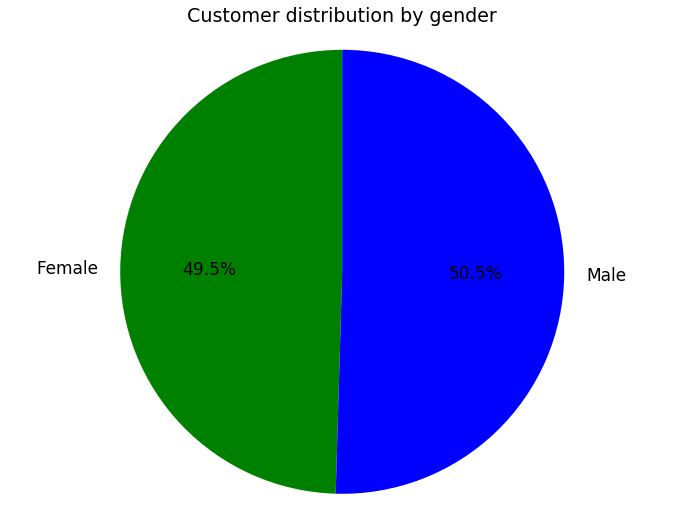

In [15]:
labels = 'Female', 'Male'
total_customers = len(telco_full)
female = telco_full[telco_full['gender']=='Female']
male = telco_full[telco_full['gender']=='Male']

sizes = [len(female)*100/total_customers, len(male)*100/total_customers]

fig1, ax1 = plt.subplots(figsize=(12,9))
ax1.set_title('Customer distribution by gender', fontsize=19)
_ = ax1.pie(sizes, labels=labels, startangle=90, shadow=False, autopct='%2.1f%%', colors=['green', 'blue'], textprops={'fontsize': 17})
_ = ax1.axis('equal')

This can also be seen with .describe

In [16]:
telco_full["gender"].describe()

count     7032
unique       2
top       Male
freq      3549
Name: gender, dtype: object

We can also take a quick look at any parameter:

In [17]:
telco_full["PhoneService"].describe()

count     7032
unique       2
top        Yes
freq      6352
Name: PhoneService, dtype: object

In [18]:
telco_full["PhoneService"].value_counts()

Yes    6352
No      680
Name: PhoneService, dtype: int64

As it turns out, some of the binary content columns (1/0 Yes/No) are int and others are objects.
So it would be easier to work with consistent formats. Given that
some parameters are not a simple yes or no I will convert SeniorCitizen with 1/0 to 
yes no (later on for modelling we will convert it back)

In [19]:
telco_full['SeniorCitizen'].replace((1, 0),('Yes', 'No'), inplace=True)

Let's try to understand a bit more the distribution of different
columns (or parameters)
I will create a grid of subplots for several parameters understanding
the distribution of clients while separating from Churned or not churned
I would also add the age range of the individual as part of churned
probability

How many customers have Churn='Yes'?

In [20]:
churned_total = telco_full[telco_full['Churn']=='Yes']
print('Percentage of churned customers:', round(len(churned_total)*100/len(telco_full),3))

Percentage of churned customers: 26.578


From the color-blind 10 palette:

In [21]:
orange = (255/255, 128/255, 14/255)
dark_blue = (0/255,107/255,164/255)
light_blue = (95/255, 158/255, 209/255)
marron = (200/255, 82/255, 0/255)

In [22]:
telco_full.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

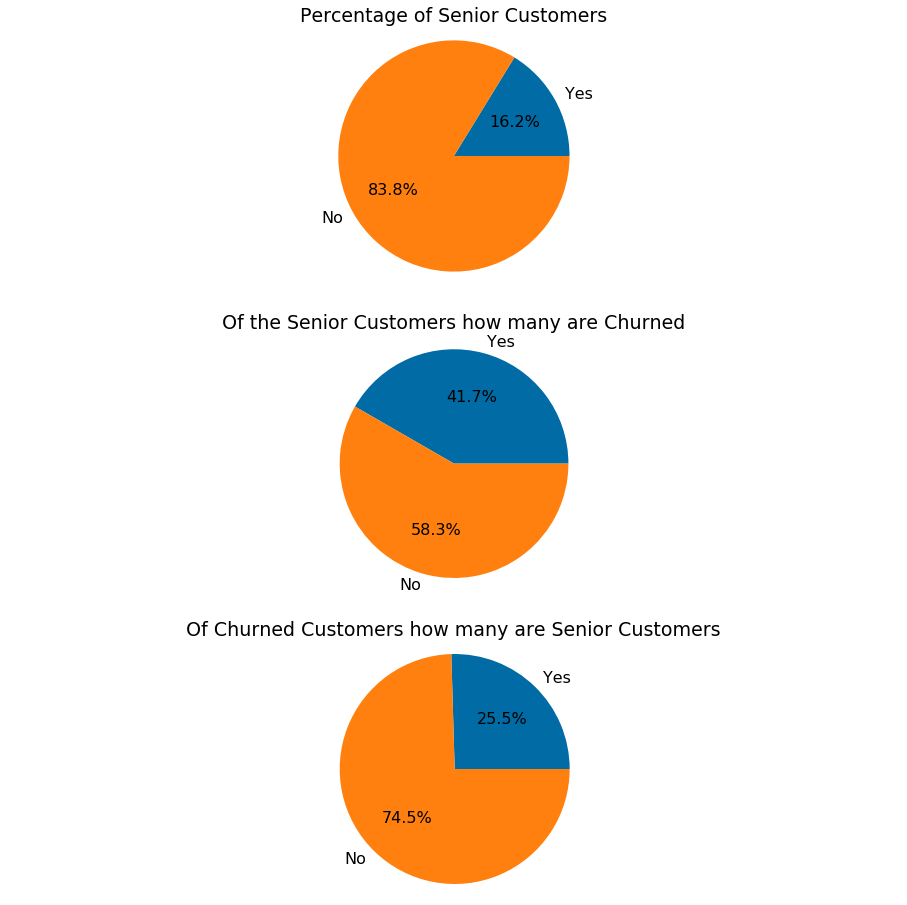

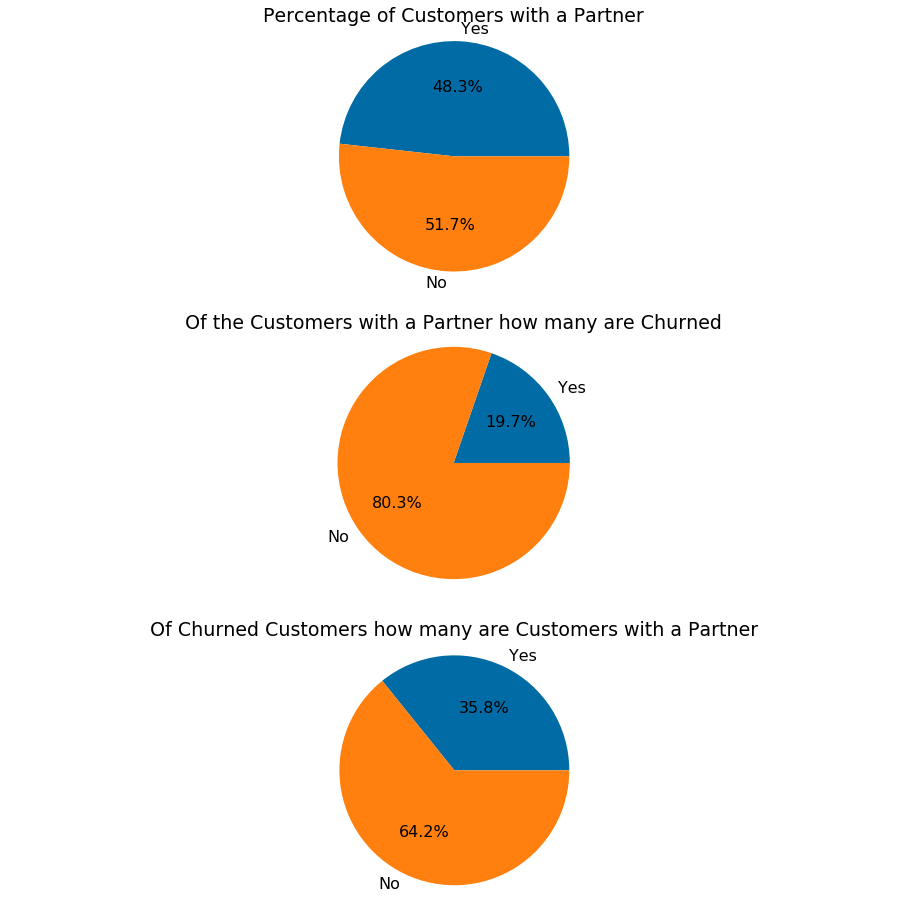

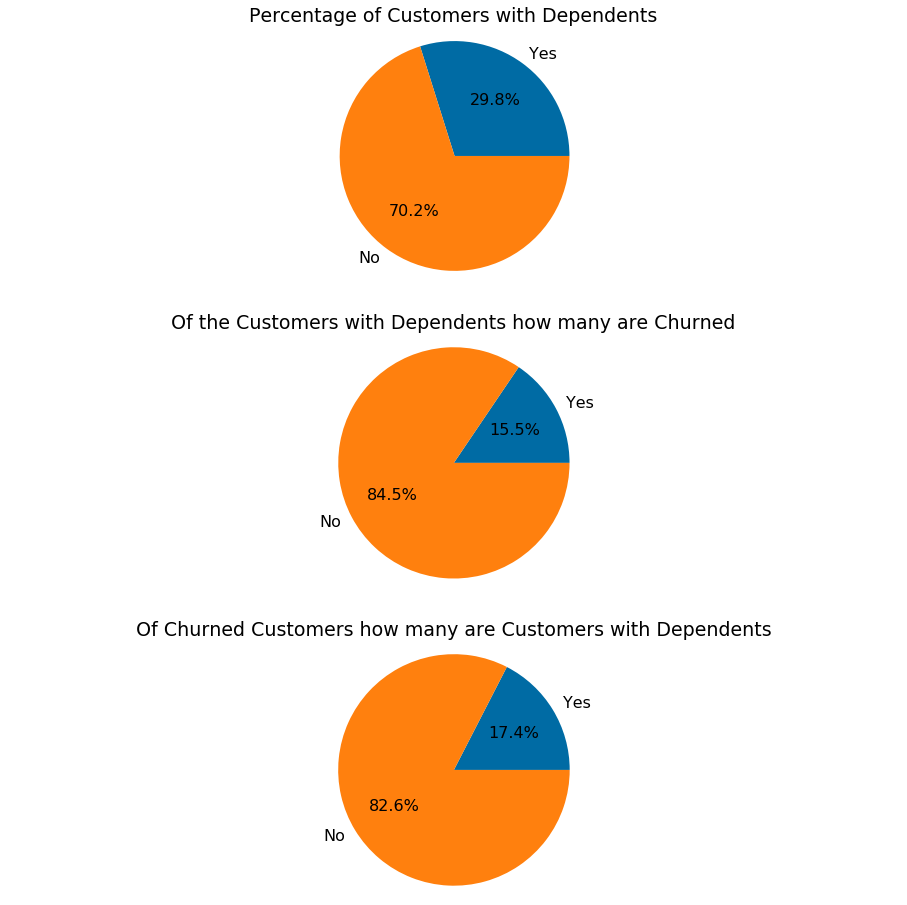

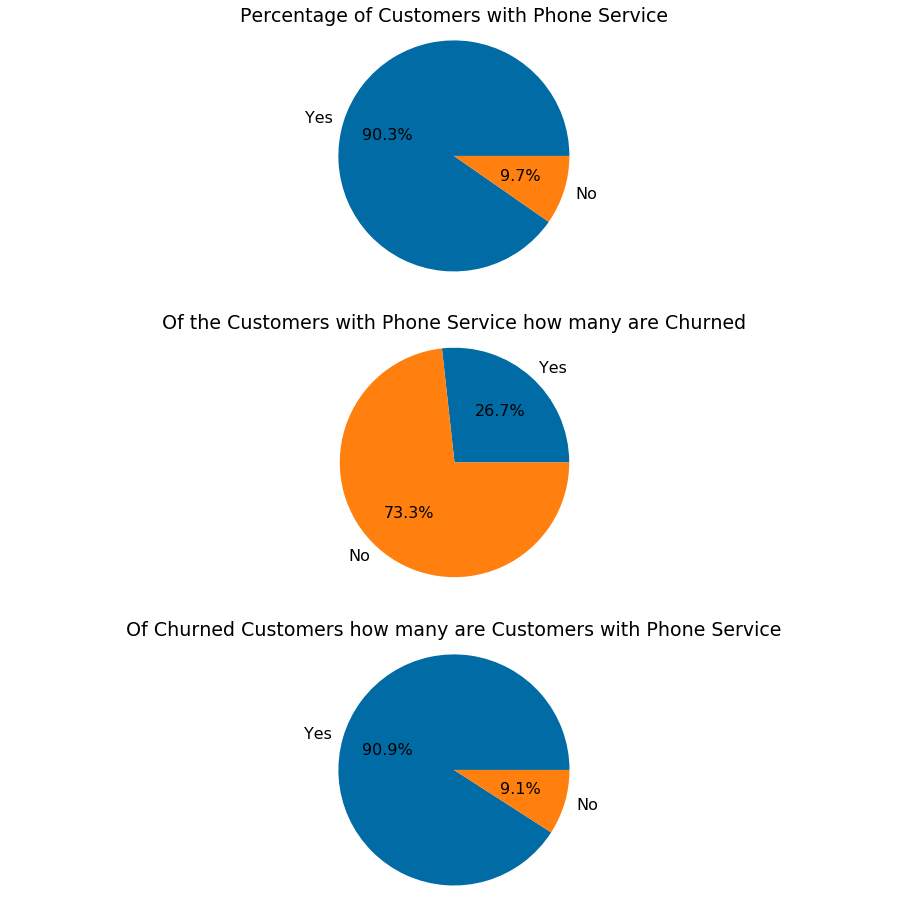

In [23]:
to_work_pie = {'SeniorCitizen':'Senior Customers', 'Partner':'Customers with a Partner', 'Dependents':'Customers with Dependents', 'PhoneService':'Customers with Phone Service'}
for each_pie in to_work_pie:
    
    fig1 = plt.figure(figsize=(16,16))
    #print(type(to_work_pie[each_pie]), each_pie)
    
    title = str(to_work_pie[each_pie])
    
    
    ### How many clients are senior citizens?
    senior_cit = telco_full[telco_full[each_pie]=='Yes']
    perc_senior = len(senior_cit)*100/len(telco_full)
    non_senior = 100 - perc_senior
    
    sizes_senior = [perc_senior, non_senior]
    labels_senior = ['Yes', 'No']
    
    ax1 = fig1.add_subplot(3,1,1)
    ax1.set_title('Percentage of '+str(to_work_pie[each_pie]), fontsize=19)
    ax1.pie(sizes_senior, labels=labels_senior, colors=[dark_blue, orange], autopct='%1.1f%%', textprops={'fontsize': 16})
    ax1.axis('equal')
    
    
    
    ## Of the senior citizens how many are churned?
    churned_senior = senior_cit[senior_cit['Churn']=='Yes']
    
    sizes_senior_ch = [len(churned_senior)*100/len(senior_cit), 100-len(churned_senior)*100/len(senior_cit)]
    labels_senior_ch = ['Yes', 'No']
    
    ax1 = fig1.add_subplot(3,1,2)
    ax1.set_title('Of the '+str(to_work_pie[each_pie])+' how many are Churned', fontsize=19)
    ax1.pie(sizes_senior_ch, labels=labels_senior_ch, colors=[dark_blue, orange], autopct='%1.1f%%', textprops={'fontsize': 16})
    ax1.axis('equal')
    
    
    ## Of all churned customers how many are senior citizens?
    
    churned = telco_full[telco_full['Churn']=='Yes']
    sen_churned = churned[churned[each_pie]=='Yes']
    
    sizes_sen_churned = [len(sen_churned)*100/len(churned), 100-len(sen_churned)*100/len(churned)]
    labels_sen_churned = ['Yes', 'No']
    
    ax1 = fig1.add_subplot(3,1,3)
    ax1.set_title('Of Churned Customers how many are '+str(to_work_pie[each_pie]), fontsize=19)
    ax1.pie(sizes_sen_churned, labels=labels_sen_churned, colors=[dark_blue, orange], autopct='%1.1f%%', textprops={'fontsize': 16})
    ax1.axis('equal')

The graphs above help us visualize the distribution of customers that are Senior Citizens, those with a Partner, Dependents or with Phone Service.
The first thing we can see is that of all customers only \~16% of them are Senior citizens, but that almost half of these senior customers have churned and these senior churned customers represent about 1/4 of all churned customers.
We can also see that although \~50% of customers have a partner, only \~20% of them have churned.
Customers with dependents have a relatively small,but still significant, churn percentage (\~15%), and that potentially having a Phone Service does not affect customer attrition (all of these feature will be analyzed below)

Other features are better seen as histograms:

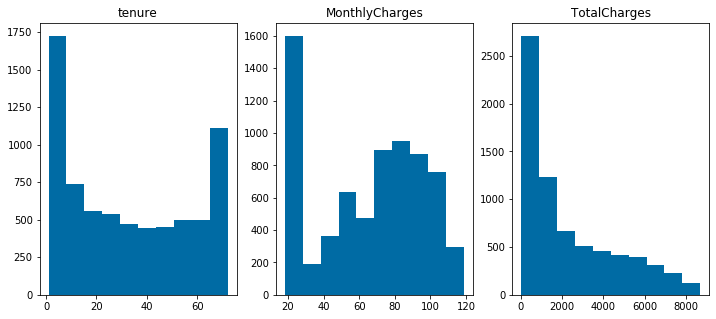

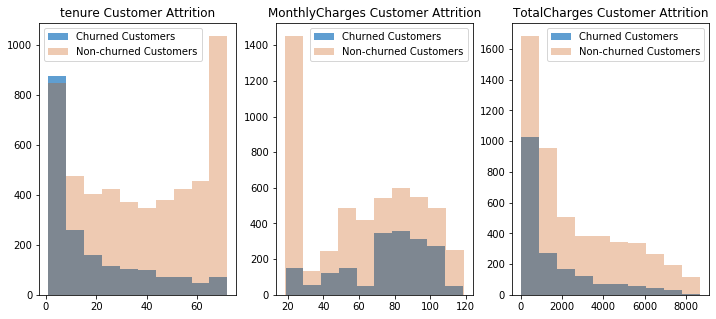

In [24]:
to_work_hist = ['tenure', 'MonthlyCharges', 'TotalCharges']
fig2 = plt.figure(figsize=(12,5))
fig3 = plt.figure(figsize=(12,5)) #fig to compare churned vs nonchurned dist
i = 1 #determines the position of the subplot in the grid

for each_hist in to_work_hist:
    
    
    ch_each = telco_full[telco_full['Churn']=='Yes']
    nch_each = telco_full[telco_full['Churn']=='No']
    
    ax1 = fig2.add_subplot(1,3,i)
    ax1.set_title(each_hist)
    ax1.hist(telco_full[each_hist][~np.isnan(telco_full[each_hist])], color=dark_blue)
    
    
    ax2 = fig3.add_subplot(1,3,i)
    ax2.set_title(each_hist+' Customer Attrition')
    ax2.hist(ch_each[each_hist][~np.isnan(ch_each[each_hist])], color=light_blue, alpha=1, zorder=1, label='Churned Customers')
    ax2.hist(nch_each[each_hist][~np.isnan(nch_each[each_hist])], color=marron, alpha=0.3, label='Non-churned Customers')
    ax2.legend()
    i = i + 1

The above distributions show us tenure (in months), Montly and Total Charges (the unit is not specified for these two). To begin with, I am going to assume that Tenure is correlated with Total Charges,since total charges seem to be the same as monthly charges for customers with a tenure of 1 month.
Tenure seems to be an important factor in customer attrition, with the distribution of churned customers being skewed towards smaller numbers of months.
ON the other hand it is interesting to undestand the peak in the low range of montly charges: is it a sale? starting customers? It would be interesting to see for this peak their time with the company and services.

For the remaining features, we can use a waffle plot:

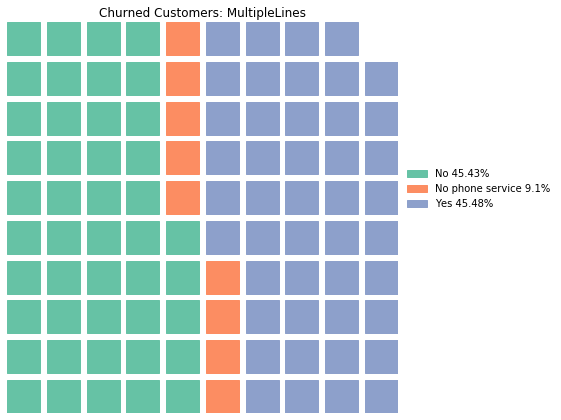

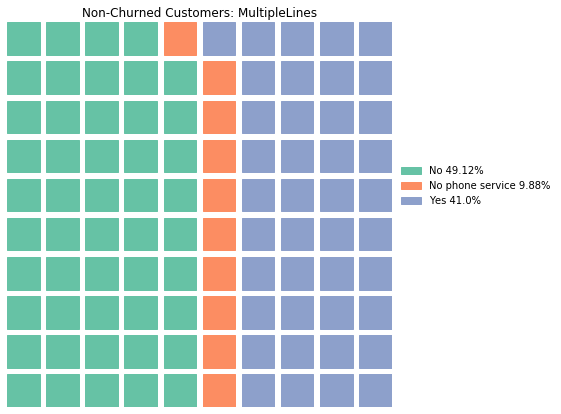

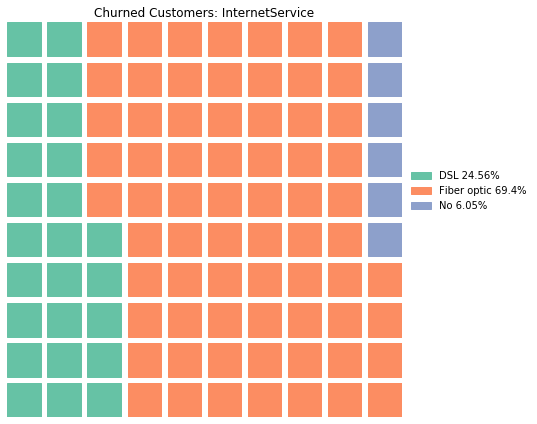

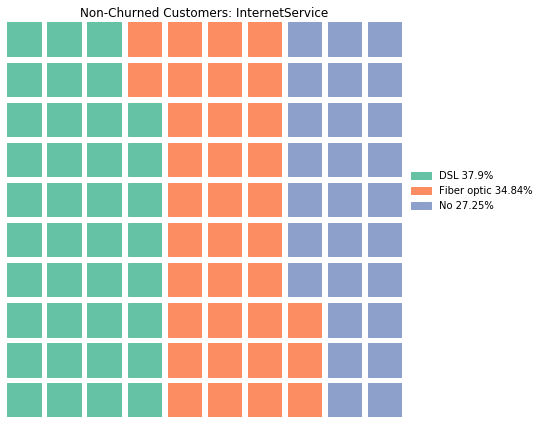

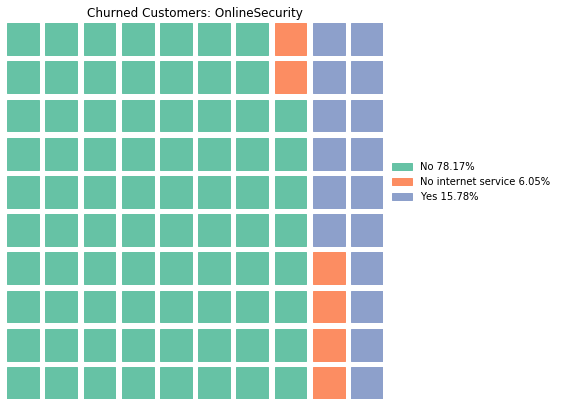

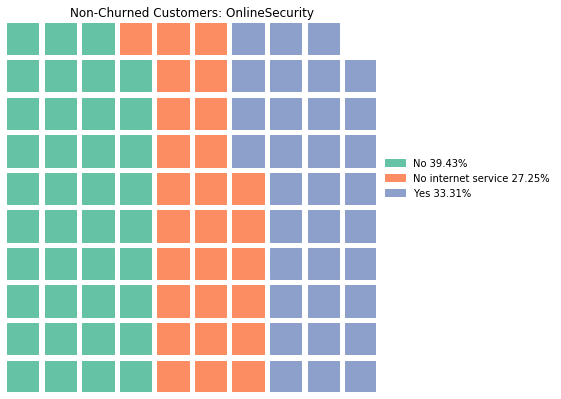

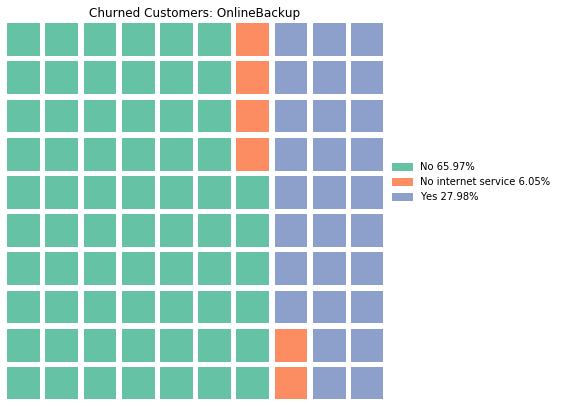

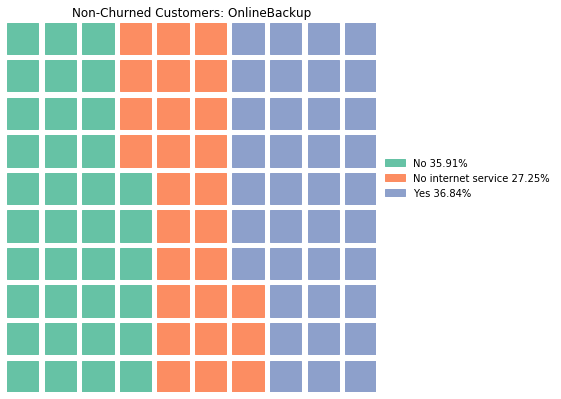

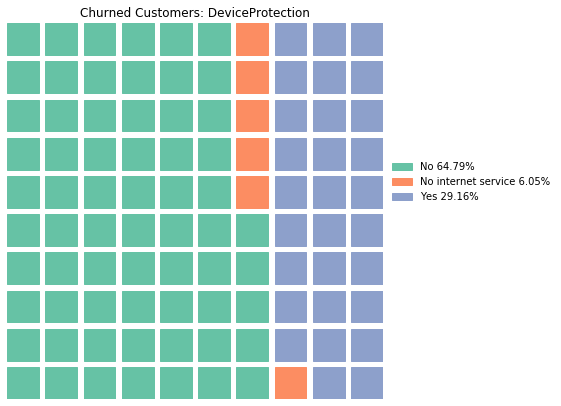

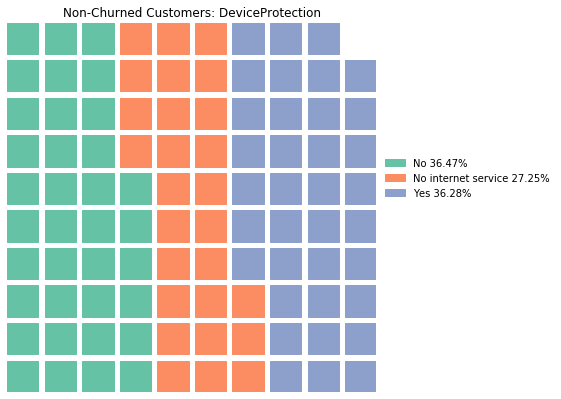

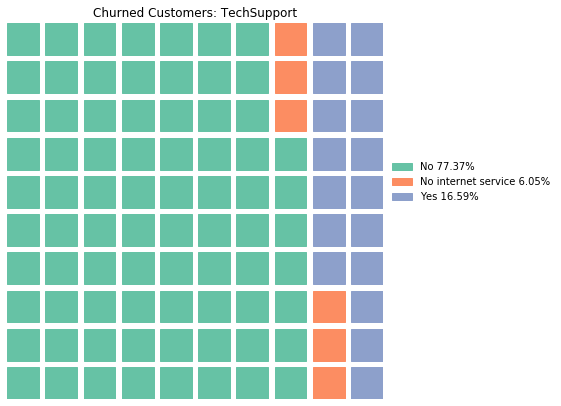

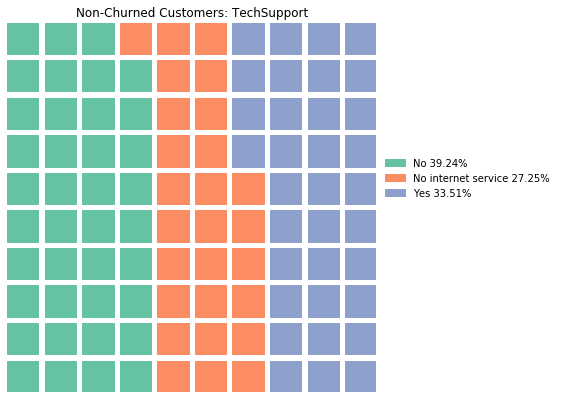

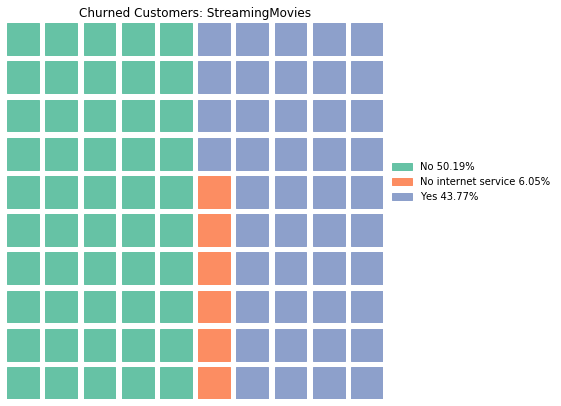

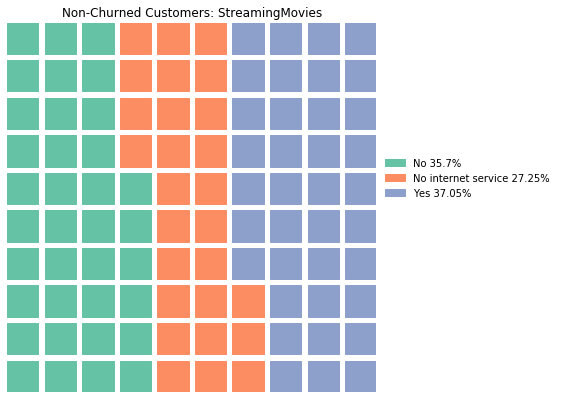

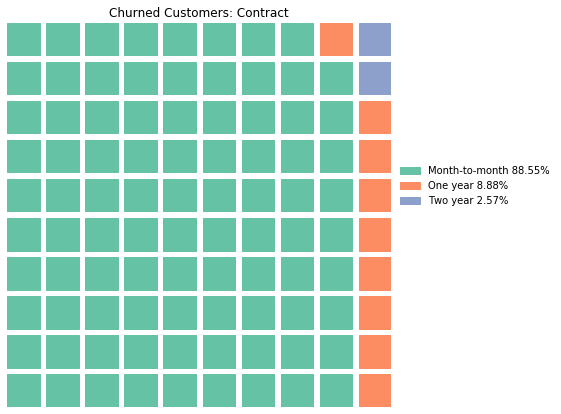

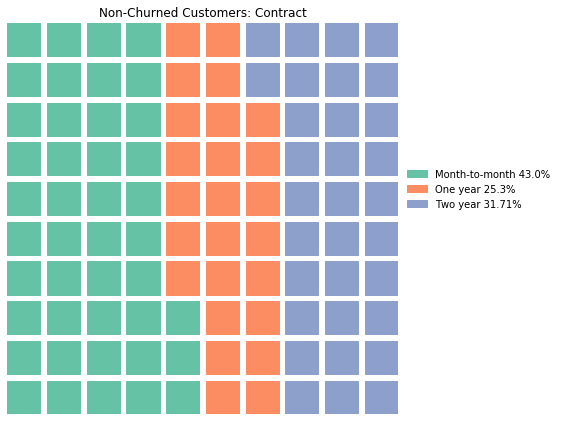

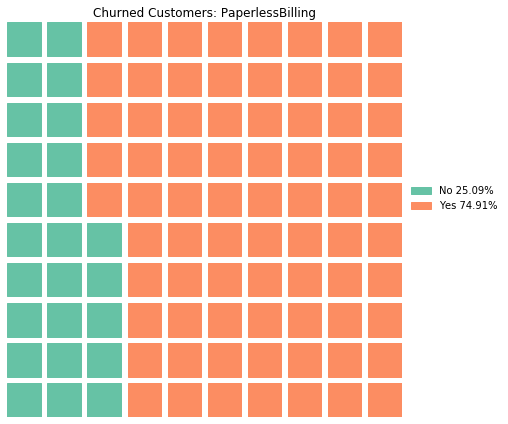

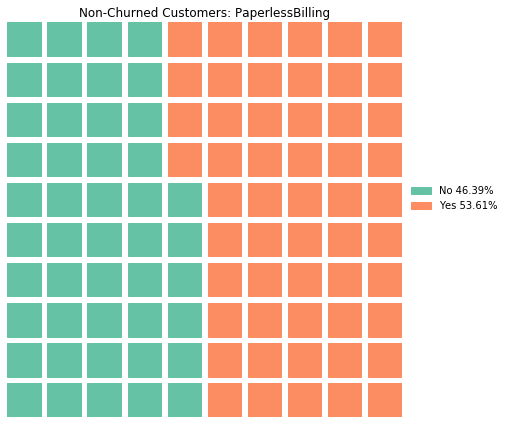

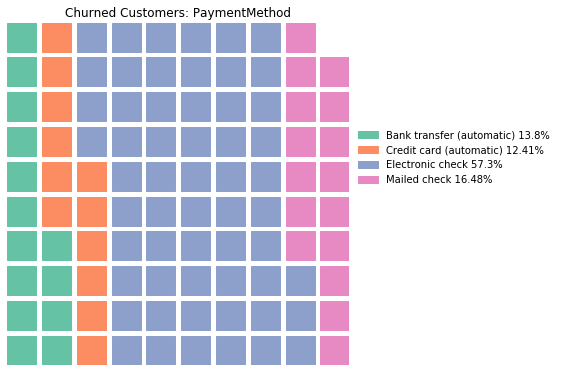

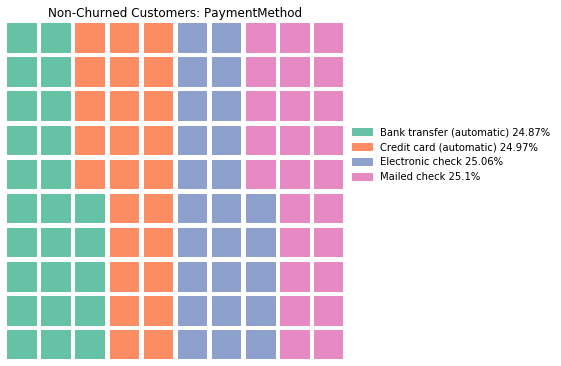

In [25]:
rem_features = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 'TechSupport', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
full_churned = telco_full[telco_full['Churn']=='Yes']
full_nchurned = telco_full[telco_full['Churn']=='No']

perc_feat_rem_ch = []
perc_feat_rem_nch = []

## DO it for one feature to understand waffles
work_with = ['MultipleLines', 'InternetService']


for feature in rem_features:
    
    to_plot = []
    to_nplot = []
    dic_labels = {}
    dic_nlabels = {}
    unique_feats = np.unique(telco_full[feature])
    
    for unif in unique_feats:
        
        ###############Churned Customers
        chrn_multi = full_churned[full_churned[feature]==unif]
        per_chr_multi = len(chrn_multi)*100/len(full_churned)
        to_plot.append(per_chr_multi)
        dic_labels[unif] = round(per_chr_multi,2)
        
        ############## NOn Churned Customers
        ##percentage of churned customers with multiple lines
        nchrn_multi = full_nchurned[full_nchurned[feature]==unif]
        per_nchr_multi = len(nchrn_multi)*100/len(full_nchurned)
        to_nplot.append(per_nchr_multi)
        dic_nlabels[unif] = round(per_nchr_multi,2)
    
    fig = plt.figure(FigureClass=Waffle, rows=10, columns=10, values=[x for x in (to_plot)],  figsize=(7,6), labels=[y+' '+str(round(dic_labels[y],2))+'%' for y in dic_labels], legend={'loc': 'lower left', 'bbox_to_anchor': (1, 0.5), 'framealpha': 0})
    plt.title('Churned Customers: '+feature)
    
    fig = plt.figure(FigureClass=Waffle, rows=10, columns=10, values=[x for x in (to_nplot)],  figsize=(7,6), labels=[y+' '+str(round(dic_nlabels[y],2))+'%' for y in dic_nlabels], legend={'loc': 'lower left', 'bbox_to_anchor': (1, 0.5), 'framealpha': 0})
    plt.title('Non-Churned Customers: '+feature)
    

Waffles are a great way to see the distribution of customers in a square area. Each square has an area of 10x10 and each feature divided as per customer attrition.

For Internet Service, it seems that most of the churned customers had Fiber optic, however some or most of these features have most likely a secondary parameter that drives attrition. For each parameters of the churned customers most have no online security, no online backup, device protection and don't use tech support.

One of the most important features is the type of contract the customer has. As expected, since  a month-to-month contract is easier to get out of, customers with this kind of contract are expected to have a higher attrition, however this percentage is really large, almost 90%.

Another important thing to note is that it is possible that users that have multiple services with the company (streaming movies, tech support, device protection, etc) are less likely to churn, given their high engagement with the company. Because of this it would be interesting to create another feature that relates each user with how many services they are suscribed for within the company.

## Feature Engineering

In [26]:
telco_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   object 
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


In [27]:
telco_full.describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


In [28]:
metrics_all = list(telco_full.columns)
metrics_all

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [29]:
to_remove = ['customerID', 'Churn'] #not part of the features
metrics = [x for x in metrics_all if x not in to_remove]
y = telco_full['Churn']
metrics

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

In [30]:
telco_full[metrics].head(10)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
5,Female,No,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50
6,Male,No,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40
7,Female,No,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90
8,Female,No,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05
9,Male,No,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95


Some columns that should be a binary output (e.g., Multiple Lines) have more than two options due to the fact that some people have no phone service (is dependent on an external factor) Given that there is in fact another column that accounts of the presence of phone service. I will convert these dependencies to a Yes/No.

In [31]:
telco_full.loc[telco_full.MultipleLines == 'No phone service', 'MultipleLines'] = 'No'

In [32]:
telco_full.loc[telco_full.OnlineSecurity == 'No internet service', 'OnlineSecurity'] = 'No'

In [33]:
telco_full.loc[telco_full.OnlineBackup == 'No internet service', 'OnlineBackup'] = 'No'

In [34]:
telco_full.loc[telco_full.DeviceProtection == 'No internet service', 'DeviceProtection'] = 'No'

In [35]:
telco_full.loc[telco_full.TechSupport == 'No internet service', 'TechSupport'] = 'No'

In [36]:
telco_full.loc[telco_full.StreamingTV == 'No internet service', 'StreamingTV'] = 'No'

In [37]:
telco_full.loc[telco_full.StreamingMovies == 'No internet service', 'StreamingMovies'] = 'No'

It would seem reasonable to assume that customers with several services from the company are less likely to churn. This is why I will create an extra column with an int value between 1-9 that represents to how many of the offered services they are signed up to.

In [38]:
telco_full['num_services'] = (telco_full[['PhoneService','MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] != 'No').sum(axis=1)

In [39]:
# to test above result
telco_full[['PhoneService','MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'num_services']].head(10)

,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,num_services
0,No,No,DSL,No,Yes,No,No,No,No,2
1,Yes,No,DSL,Yes,No,Yes,No,No,No,4
2,Yes,No,DSL,Yes,Yes,No,No,No,No,4
3,No,No,DSL,Yes,No,Yes,Yes,No,No,4
4,Yes,No,Fiber optic,No,No,No,No,No,No,2
5,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,6
6,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,5
7,No,No,DSL,Yes,No,No,No,No,No,2
8,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,7
9,Yes,No,DSL,Yes,Yes,No,No,No,No,4


In [40]:
metrics.append('num_services')

In [41]:
metrics

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'num_services']

In [42]:
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'num_services']
binary_features = [i for i in metrics if len(telco_full[i].unique())==2]
multi_features = [i for i in metrics if len(telco_full[i].unique())>2 and i not in num_features]

In [43]:
'Binary: ', binary_features, 'Multi: ', multi_features

('Binary: ',
 ['gender',
  'SeniorCitizen',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'PaperlessBilling'],
 'Multi: ',
 ['InternetService', 'Contract', 'PaymentMethod'])

## Feature Distributions

In [44]:
telco_full.shape

(7032, 22)

In [45]:
telco_full[metrics].describe()

,tenure,MonthlyCharges,TotalCharges,num_services
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441,4.147184
std,24.545260,30.085974,2266.771362,2.312294
min,1.000000,18.250000,18.800000,1.000000
25%,9.000000,35.587500,401.450000,2.000000
50%,29.000000,70.350000,1397.475000,4.000000
75%,55.000000,89.862500,3794.737500,6.000000
max,72.000000,118.750000,8684.800000,9.000000


## Numerical Features

In [46]:
scaler = StandardScaler()
telco_full[num_features] = scaler.fit_transform(telco_full[num_features])

telco_full.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,num_services
0,7590-VHVEG,Female,No,Yes,No,-1.280248,No,No,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,-1.161694,-0.994194,No,-0.928661
1,5575-GNVDE,Male,No,No,No,0.064303,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,-0.260878,-0.173740,No,-0.063657
2,3668-QPYBK,Male,No,No,No,-1.239504,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,-0.363923,-0.959649,Yes,-0.063657
3,7795-CFOCW,Male,No,No,No,0.512486,No,No,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),-0.747850,-0.195248,No,-0.063657
4,9237-HQITU,Female,No,No,No,-1.239504,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,0.196178,-0.940457,Yes,-0.928661


## Dealing with categorical features

In [47]:
telco_full.PhoneService.value_counts()

Yes    6352
No      680
Name: PhoneService, dtype: int64

In [48]:
telco_full.MultipleLines.value_counts()

No     4065
Yes    2967
Name: MultipleLines, dtype: int64

In [49]:
telco_full.shape

(7032, 22)

In [50]:
telco_full.MultipleLines.value_counts()

No     4065
Yes    2967
Name: MultipleLines, dtype: int64

In [51]:
telco_full.InternetService.value_counts()

Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64

In [52]:
telco_full.Contract.value_counts()

Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64

In [53]:
telco_full.PaymentMethod.value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

Transforming binary features into 1/0 instead of Yes No

In [54]:
for each_bin in binary_features:
    
    telco_full[each_bin].replace(('Yes', 'No'),(1, 0), inplace=True)

telco_full.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,num_services
0,7590-VHVEG,Female,0,1,0,-1.280248,0,0,DSL,0,...,0,0,0,Month-to-month,1,Electronic check,-1.161694,-0.994194,No,-0.928661
1,5575-GNVDE,Male,0,0,0,0.064303,1,0,DSL,1,...,0,0,0,One year,0,Mailed check,-0.260878,-0.173740,No,-0.063657
2,3668-QPYBK,Male,0,0,0,-1.239504,1,0,DSL,1,...,0,0,0,Month-to-month,1,Mailed check,-0.363923,-0.959649,Yes,-0.063657
3,7795-CFOCW,Male,0,0,0,0.512486,0,0,DSL,1,...,1,0,0,One year,0,Bank transfer (automatic),-0.747850,-0.195248,No,-0.063657
4,9237-HQITU,Female,0,0,0,-1.239504,1,0,Fiber optic,0,...,0,0,0,Month-to-month,1,Electronic check,0.196178,-0.940457,Yes,-0.928661


In [55]:
telco_full['gender'].replace(('Male', 'Female'),(1, 0), inplace=True)

In [56]:
telco_full[binary_features].head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling
0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,1,0,0,0,1,0,1,0,1,0,0,0,0
2,1,0,0,0,1,0,1,1,0,0,0,0,1
3,1,0,0,0,0,0,1,0,1,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1


## Multi-class features

For features with more than one options (not just only yes/no) we use get_dummies

In [57]:
telco_full = pd.get_dummies(telco_full, prefix=multi_features, columns=multi_features)
telco_full.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,-1.280248,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,0.064303,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,1,0,0,0,-1.239504,1,0,1,1,...,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,0.512486,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
4,9237-HQITU,0,0,0,0,-1.239504,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [58]:
telco_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 29 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7032 non-null   object 
 1   gender                                   7032 non-null   int64  
 2   SeniorCitizen                            7032 non-null   int64  
 3   Partner                                  7032 non-null   int64  
 4   Dependents                               7032 non-null   int64  
 5   tenure                                   7032 non-null   float64
 6   PhoneService                             7032 non-null   int64  
 7   MultipleLines                            7032 non-null   int64  
 8   OnlineSecurity                           7032 non-null   int64  
 9   OnlineBackup                             7032 non-null   int64  
 10  DeviceProtection                         7032 no

In [59]:
target = 'Churn'
not_features  = ['Churn', 'customerID']

features = [i for i in telco_full.columns if i not in not_features]
features

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges',
 'num_services',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [60]:
df = telco_full[features]
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1.280248,0,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0.064303,1,0,1,0,1,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,-1.239504,1,0,1,1,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,0.512486,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,-1.239504,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [61]:
correlations = df.corr()

In [62]:
correlations.style.background_gradient(cmap='coolwarm').set_precision(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,num_services,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
gender,1.00,-0.00,-0.00,0.01,0.01,-0.01,-0.01,-0.02,-0.01,-0.00,-0.01,-0.01,-0.01,-0.01,-0.01,0.00,-0.02,0.01,-0.01,0.00,-0.00,0.01,-0.00,-0.02,0.00,0.00,0.01
SeniorCitizen,-0.00,1.00,0.02,-0.21,0.02,0.01,0.14,-0.04,0.07,0.06,-0.06,0.11,0.12,0.16,0.22,0.10,0.12,-0.11,0.25,-0.18,0.14,-0.05,-0.12,-0.02,-0.02,0.17,-0.15
Partner,-0.00,0.02,1.00,0.45,0.38,0.02,0.14,0.14,0.14,0.15,0.12,0.12,0.12,-0.01,0.10,0.32,0.20,-0.00,0.00,-0.00,-0.28,0.08,0.25,0.11,0.08,-0.08,-0.10
Dependents,0.01,-0.21,0.45,1.00,0.16,-0.00,-0.02,0.08,0.02,0.01,0.06,-0.02,-0.04,-0.11,-0.11,0.06,-0.01,0.05,-0.16,0.14,-0.23,0.07,0.20,0.05,0.06,-0.15,0.06
tenure,0.01,0.02,0.38,0.16,1.00,0.01,0.33,0.33,0.36,0.36,0.33,0.28,0.29,0.00,0.25,0.83,0.47,0.01,0.02,-0.04,-0.65,0.20,0.56,0.24,0.23,-0.21,-0.23
PhoneService,-0.01,0.01,0.02,-0.00,0.01,1.00,0.28,-0.09,-0.05,-0.07,-0.10,-0.02,-0.03,0.02,0.25,0.11,0.08,-0.45,0.29,0.17,-0.00,-0.00,0.00,0.01,-0.01,0.00,-0.00
MultipleLines,-0.01,0.14,0.14,-0.02,0.33,0.28,1.00,0.10,0.20,0.20,0.10,0.26,0.26,0.16,0.49,0.47,0.52,-0.20,0.37,-0.21,-0.09,-0.00,0.11,0.08,0.06,0.08,-0.23
OnlineSecurity,-0.02,-0.04,0.14,0.08,0.33,-0.09,0.10,1.00,0.28,0.27,0.35,0.18,0.19,-0.00,0.30,0.41,0.52,0.32,-0.03,-0.33,-0.25,0.10,0.19,0.09,0.12,-0.11,-0.08
OnlineBackup,-0.01,0.07,0.14,0.02,0.36,-0.05,0.20,0.28,1.00,0.30,0.29,0.28,0.27,0.13,0.44,0.51,0.60,0.16,0.17,-0.38,-0.16,0.08,0.11,0.09,0.09,-0.00,-0.17
DeviceProtection,-0.00,0.06,0.15,0.01,0.36,-0.07,0.20,0.27,0.30,1.00,0.33,0.39,0.40,0.10,0.48,0.52,0.66,0.15,0.18,-0.38,-0.23,0.10,0.17,0.08,0.11,-0.00,-0.19


Some of the most prominent correlations that I can see are not unexpected: Tenure is highly correlated with the total charges of the customer as well as monthly charges with how many services they have.

Other interesting correlations include montly charges with Fiber optic (being in general more expensive than DSL), customers with no internet service also seem to have lower montly charges.

In [63]:
df.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
count,7032.000000,7032.000000,7032.000000,7032.000000,7.032000e+03,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.504693,0.162400,0.482509,0.298493,-1.214741e-16,0.903299,0.421928,0.286547,0.344852,0.343857,...,0.343572,0.440273,0.216155,0.551052,0.209329,0.239619,0.219283,0.216297,0.336320,0.228100
std,0.500014,0.368844,0.499729,0.457629,1.000071e+00,0.295571,0.493902,0.452180,0.475354,0.475028,...,0.474934,0.496455,0.411650,0.497422,0.406858,0.426881,0.413790,0.411748,0.472483,0.419637
min,0.000000,0.000000,0.000000,0.000000,-1.280248e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,-9.542963e-01,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,-1.394171e-01,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,9.199259e-01,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.612573e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## PCA 3D visualization
Let's try to visualize our features and corresponding target:

In [64]:
df.isnull().any().any()

False

In [65]:
from sklearn.decomposition import PCA

pca3d = PCA(n_components=3)

df3d = pca3d.fit_transform(df)

In [66]:
df3d

array([[-2.1458255 , -0.48439932,  0.76674443],
       [-0.42893119,  0.59660726,  0.99941196],
       [-1.39036564, -0.79809683,  1.28883903],
       ...,
       [-1.96052512, -0.03943392,  0.80680481],
       [-1.12179687, -1.31145209, -0.63687016],
       [ 3.22357057,  0.44553452, -0.19970294]])

In [67]:
df3d.shape

(7032, 3)

In [68]:
np.unique(y)

array(['No', 'Yes'], dtype=object)

In [69]:
y_num = [1 if x=='Yes' else 0 for x in y]
np.unique(y_num), y_num[0], y_num[20], y_num[50]

(array([0, 1]), 0, 1, 0)

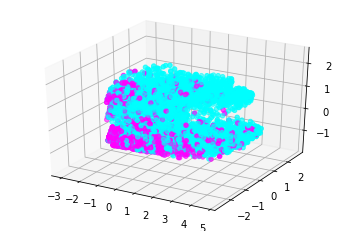

In [70]:
from mpl_toolkits import mplot3d


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(df3d[:,0], df3d[:,1], df3d[:,2], c=y_num, cmap='cool');

# Modelling

In [71]:
y = telco_full[target]
y.shape, df.shape

((7032,), (7032, 27))

In [72]:
y.replace(('Yes', 'No'),(1, 0), inplace=True)
y.unique()

array([0, 1], dtype=int64)

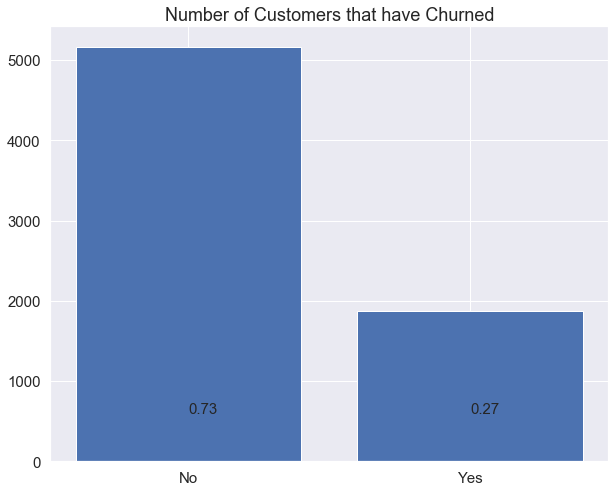

In [128]:
proportion_classes(y, [1, 0], ['Yes','No'], 'Number of Customers that have Churned')

In [74]:
X = df

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=42)
Xtrain.shape, Xval.shape, Xtest.shape, ytrain.shape, yval.shape, ytest.shape

((3445, 27), (1477, 27), (2110, 27), (3445,), (1477,), (2110,))

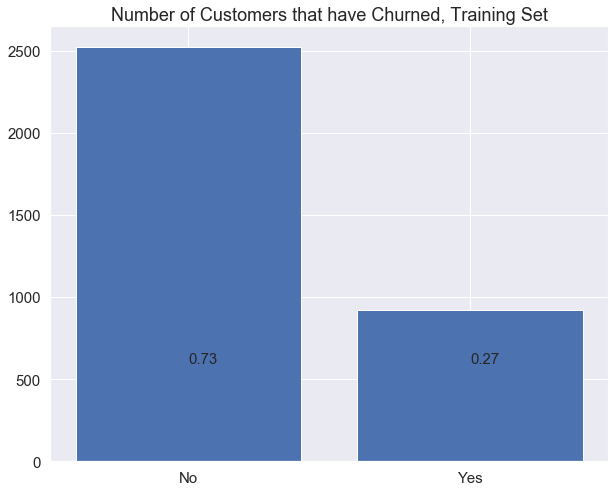

In [129]:
proportion_classes(ytrain, [1, 0], ['Yes','No'], 'Number of Customers that have Churned, Training Set')

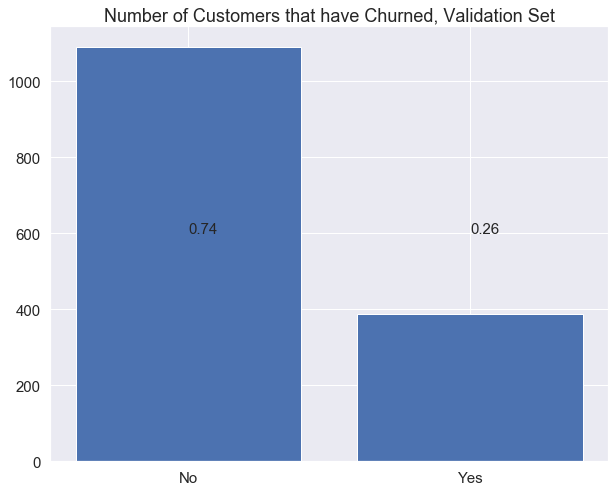

In [130]:
proportion_classes(yval, [1, 0], ['Yes','No'], 'Number of Customers that have Churned, Validation Set')

Since we are trying to catch users that might churn, I've decided to focus on recall. However this largely depends on how much it costs the company to either loose a client vs. getting false positives (labeling a user as potential churn when in reality it was not going to churn)

## Base model: Not fine-tuned Random Forest
As starting point with our most basic model, we start with a Random Forest classifier, first without hyperparameter tunning and then using GridSearchCV to do hyperparameter tunning.

In [80]:
import sklearn
sklearn.__version__

'0.22.1'

In [81]:
forest_simple = RandomForestClassifier(random_state=22)

In [82]:
forest_simple

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [83]:
fit_simple_forest = forest_simple.fit(Xtrain, ytrain)
fit_simple_forest

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=22, verbose=0,
                       warm_start=False)

In [84]:
y_simple_forest = fit_simple_forest.predict(Xval)
y_simple_forest_prob = fit_simple_forest.predict_proba(Xval)
y_simple_forest_features = fit_simple_forest.feature_importances_
np.c_[y_simple_forest_features, Xval.columns]

array([[0.026029593801333312, 'gender'],
       [0.02077804543773702, 'SeniorCitizen'],
       [0.023121171277716845, 'Partner'],
       [0.018781069868726755, 'Dependents'],
       [0.15035449395818273, 'tenure'],
       [0.006120703251455084, 'PhoneService'],
       [0.01677829670152235, 'MultipleLines'],
       [0.01821303234046913, 'OnlineSecurity'],
       [0.019035733023370156, 'OnlineBackup'],
       [0.01602822253432456, 'DeviceProtection'],
       [0.016716463183138144, 'TechSupport'],
       [0.014861202900096755, 'StreamingTV'],
       [0.015422592487196051, 'StreamingMovies'],
       [0.025529227011361306, 'PaperlessBilling'],
       [0.16069602902584462, 'MonthlyCharges'],
       [0.17017837145398346, 'TotalCharges'],
       [0.04727276791312026, 'num_services'],
       [0.012393738125348408, 'InternetService_DSL'],
       [0.03805121622993656, 'InternetService_Fiber optic'],
       [0.014316090895384985, 'InternetService_No'],
       [0.06884514549139169, 'Contract_Month-

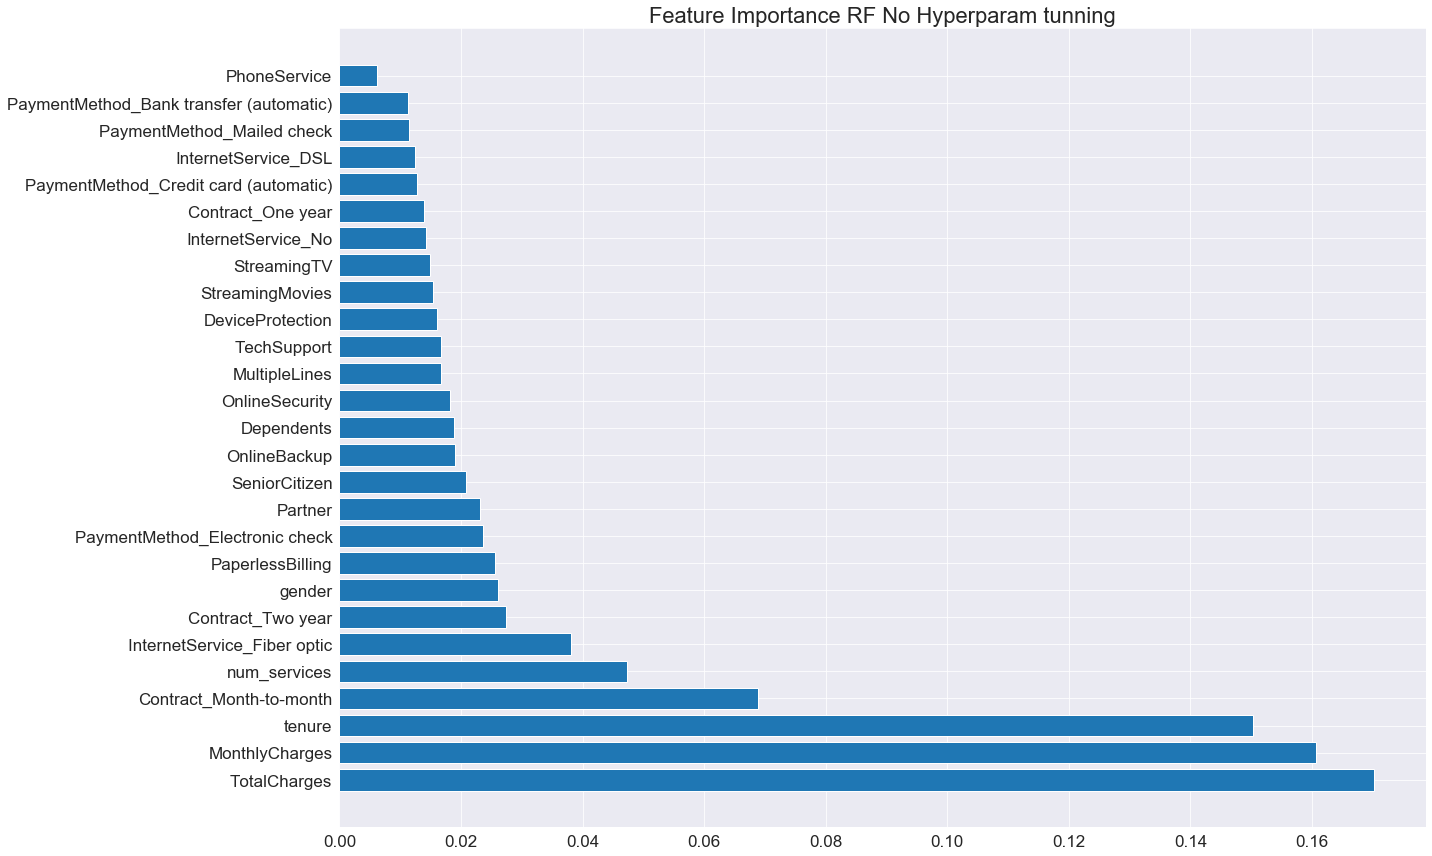

In [85]:
plot_feature_importance(y_simple_forest_features, Xval.columns, 'RF No Hyperparam tunning', Xval)

From the feature importance result, we can see that monthly charges, tenure, total charges, number of services and a month-to-month contract are the most reliable features to predict whether or not a user will churn. 

In [86]:
print(classification_report(yval, y_simple_forest))

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1090
           1       0.63      0.53      0.58       387

    accuracy                           0.80      1477
   macro avg       0.74      0.71      0.72      1477
weighted avg       0.79      0.80      0.79      1477



In [87]:
'Accuracy: ', accuracy_score(yval, y_simple_forest),'Precision: ', precision_score(yval, y_simple_forest), 'Recall', recall_score(yval, y_simple_forest)

('Accuracy: ',
 0.7962085308056872,
 'Precision: ',
 0.6310975609756098,
 'Recall',
 0.5348837209302325)

In [88]:
confusion_matrix(yval, y_simple_forest)

array([[969, 121],
       [180, 207]], dtype=int64)

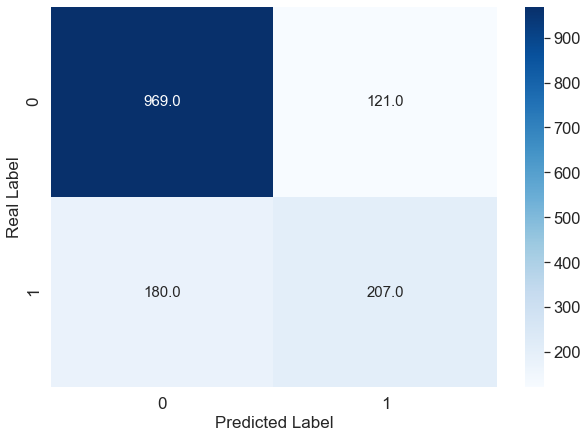

In [89]:
plot_confusion_matrix(yval, y_simple_forest) 

Looking at the confusion matrix of our validation set we can see that the simple Random Forest model is missing a significant population of customers that have churned (1) and is classifying them as not likely to churn.

That result is also presented in the low recall of this classifier.

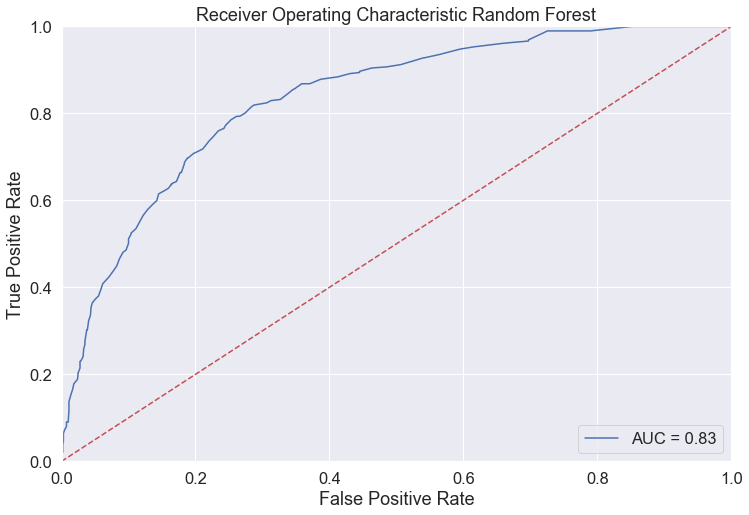

In [90]:
roc_curve_plot(Xval, yval, forest_simple, 'Random Forest')

We are clearly not getting good results from this model. The first thing I will try is increase the complexity of our model and then deal with class imbalance possibilities.

# XGBoost + Hyperparam tunning

In [91]:
param_gridxg = { 
    'learning_rate':[0.01, 0.1, 0.3, 0.35],
    'n_estimators': [50, 100, 200, 250],
    'max_depth' : [4,5,6,7],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

xg = xgb.XGBClassifier()

grid_xg = GridSearchCV(estimator=xg, param_grid=param_gridxg, cv=5, scoring='recall')

In [92]:
grid_xg

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.1, 0.3, 0.35],
                         'max_depth': [4, 5, 6, 7

In [93]:
grid_xg.fit(Xtrain, ytrain)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'learning_rate': [0.01, 0.1, 0.3, 0.35],
                         'max_depth': [4, 5, 6, 7

In [94]:
grid_xg.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 4,
 'n_estimators': 50}

In [95]:
grid_xg.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [96]:
# comparing the performance with a larger parameter space but using Random Search

param_gridxg2 = { 
    'learning_rate':[0.01, 0.1, 0.3, 0.35],
    'n_estimators': [50, 70, 100, 200, 250],
    'max_depth' : [4,5,6,7],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

grid_xg2 = RandomizedSearchCV(estimator=xg, param_distributions=param_gridxg2, cv=5, scoring='recall', random_state=37)

In [97]:
grid_xg2.fit(Xtrain, ytrain)

print(grid_xg2.best_params_)

{'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.5}


In [98]:
y_xg = grid_xg2.predict(Xval)
y_xg_prob = grid_xg2.predict_proba(Xval)


y_xg_features = grid_xg2.best_estimator_.feature_importances_

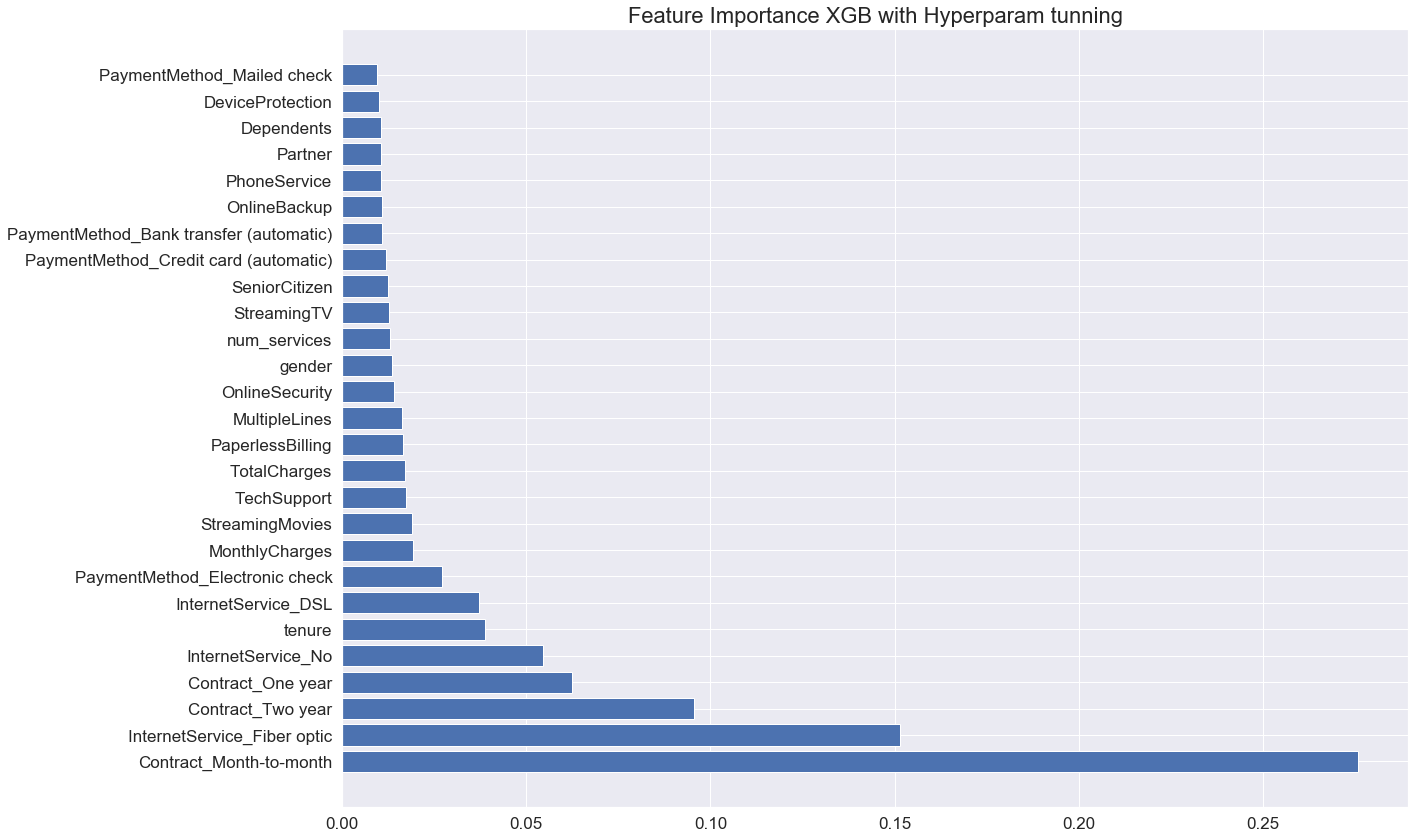

In [99]:
plot_feature_importance(y_xg_features, Xval.columns, 'XGB with Hyperparam tunning', Xval)

When we compare the feature importance results between our Random Forest and XGBoost model we see that both models claim having a month-to-month contract is one of the top 5 features that determine who is likely to churn (For XGBoost this is the most important feature). However some features seen by XGBoost as important (contract one or two years) and the kind of internet service  you have seems to be lower in importance for Random Forest.

In [100]:
print(classification_report(yval, y_xg))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1090
           1       0.63      0.55      0.59       387

    accuracy                           0.80      1477
   macro avg       0.74      0.72      0.73      1477
weighted avg       0.79      0.80      0.79      1477



All success metrics are marginally better with XGBoost, but recall is still very low for churned individuals.

In [101]:
'Accuracy: ', accuracy_score(yval, y_xg),'Precision: ', precision_score(yval, y_xg), 'Recall', recall_score(yval, y_xg)

('Accuracy: ',
 0.7989167230873392,
 'Precision: ',
 0.6339285714285714,
 'Recall',
 0.5503875968992248)

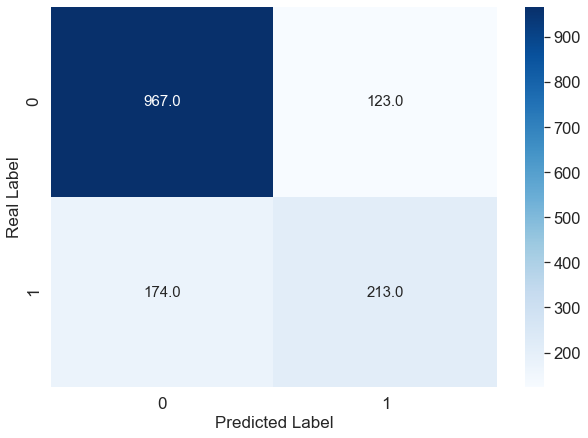

In [102]:
plot_confusion_matrix(yval, y_xg)

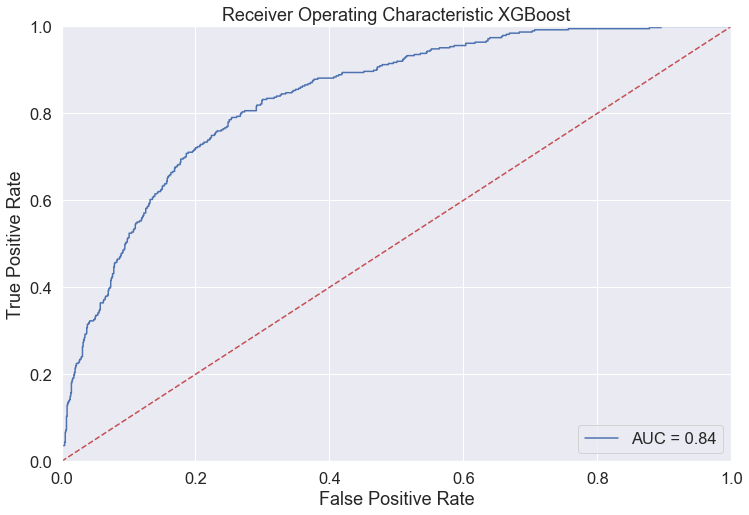

In [103]:
roc_curve_plot(Xval, yval, grid_xg2, 'XGBoost')

## Dealing with Class imbalance
In order to understand and deal with a class imbalance problem I will create two different scenarions: In one I will undersample the majority class and in the second one I will create synthetic data (SMOTE) for the minority class.

By undersampling the majority class, it is possible the classifier decreases its precision of those users that will not churn but I want to maintain the full set of those that have churned for fear of biases, if I try to oversample the minority class I might include a bias that will make its performance worst in some cases.

XGBoost model is performing only slightly better than our previous Random Forest model. Recall, is still very low for churned customers. It is likely the performance is driven by class imbalance.

### Undersampling: OneSidedSelection

In [104]:
from imblearn.under_sampling import OneSidedSelection

In [105]:
X.shape, y.shape

((7032, 27), (7032,))

In [106]:
oss_undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=42)

In [107]:
Xoss, yoss = oss_undersample.fit_resample(X, y)

In [108]:
Xoss.shape, yoss.shape

((4989, 27), (4989,))

In [109]:
Xtrainoss, Xtestoss, ytrainoss, ytestoss = train_test_split(Xoss, yoss, test_size=0.3, random_state=42)
Xtrainoss, Xvaloss, ytrainoss, yvaloss = train_test_split(Xtrainoss, ytrainoss, test_size=0.3, random_state=42)

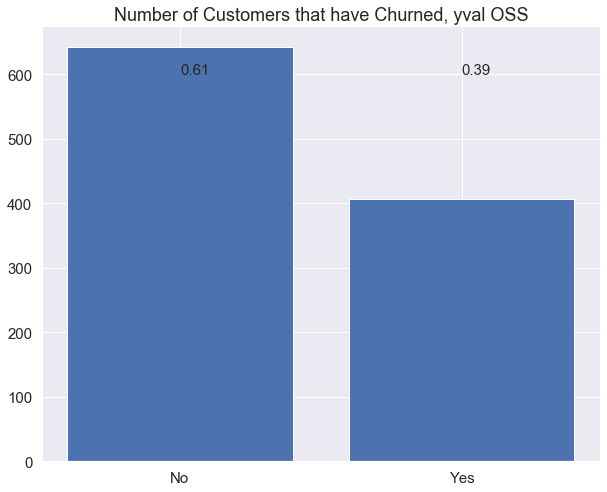

In [132]:
proportion_classes(yvaloss, [1, 0], ['Yes','No'], 'Number of Customers that have Churned, yval OSS')

In [111]:
Xtrainoss.shape, Xtestoss.shape, Xvaloss.shape

((2444, 27), (1497, 27), (1048, 27))

In [112]:
param_gridxg_oss = { 
    'learning_rate':[0.01, 0.1, 0.3, 0.35],
    'n_estimators': [50, 70, 100, 200, 250],
    'max_depth' : [4,5,6,7],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

grid_xg_oss = RandomizedSearchCV(estimator=xg, param_distributions=param_gridxg_oss, cv=5, scoring='recall', random_state=37)

In [113]:
grid_xg_oss.fit(Xtrainoss, ytrainoss)

grid_xg_oss.best_params_

{'n_estimators': 50,
 'max_depth': 4,
 'learning_rate': 0.3,
 'colsample_bytree': 0.3}

In [114]:
y_xgoss = grid_xg_oss.predict(Xvaloss)
y_xg_proboss = grid_xg_oss.predict_proba(Xvaloss)


y_xg_features_oss = grid_xg_oss.best_estimator_.feature_importances_

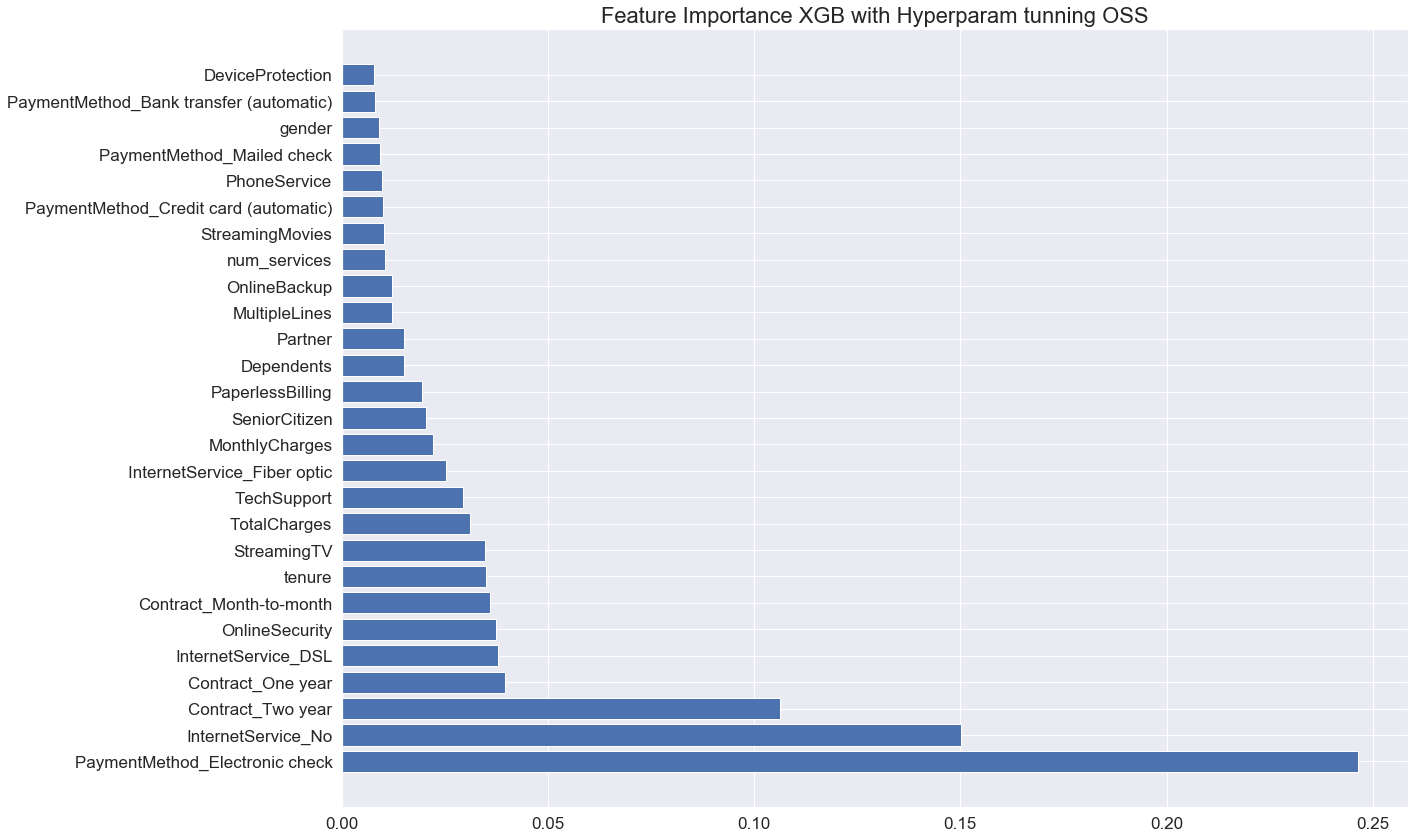

In [115]:
plot_feature_importance(y_xg_features_oss, Xvaloss.columns, 'XGB with Hyperparam tunning OSS', Xvaloss)

In [116]:
print(classification_report(yvaloss, y_xgoss))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       642
           1       0.72      0.67      0.70       406

    accuracy                           0.77      1048
   macro avg       0.76      0.75      0.76      1048
weighted avg       0.77      0.77      0.77      1048



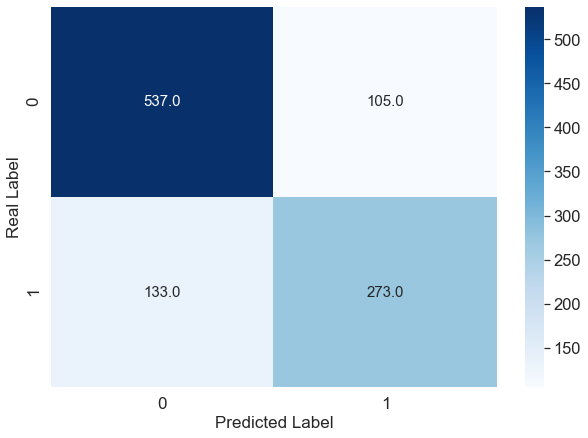

In [117]:
plot_confusion_matrix(yvaloss, y_xgoss)

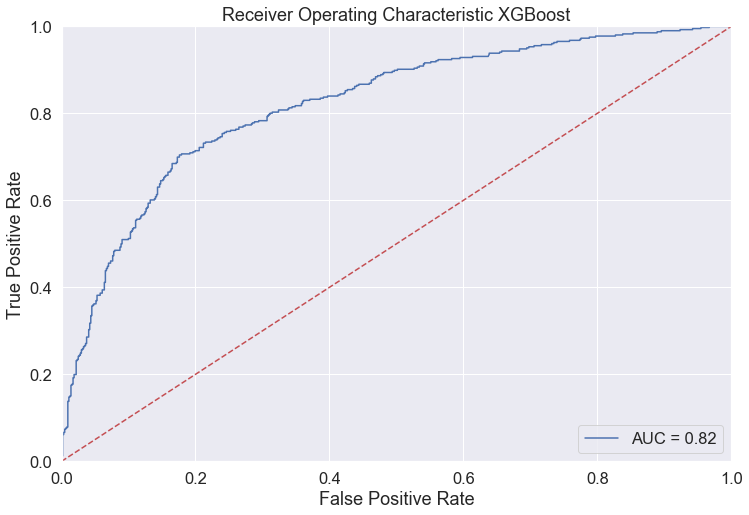

In [118]:
roc_curve_plot(Xvaloss, yvaloss, grid_xg_oss, 'XGBoost')

# Oversampling: SMOTE

In [119]:
from imblearn.over_sampling import SMOTE

In [120]:
smote_over = SMOTE()

In [121]:
Xsm, ysm = smote_over.fit_resample(X, y)
Xsm.shape, ysm.shape

((10326, 27), (10326,))

In [122]:
Xtrainsm, Xtestsm, ytrainsm, ytestsm = train_test_split(Xsm, ysm, test_size=0.3, random_state=42)
Xtrainsm, Xvalsm, ytrainsm, yvalsm = train_test_split(Xtrainsm, ytrainsm, test_size=0.3, random_state=42)

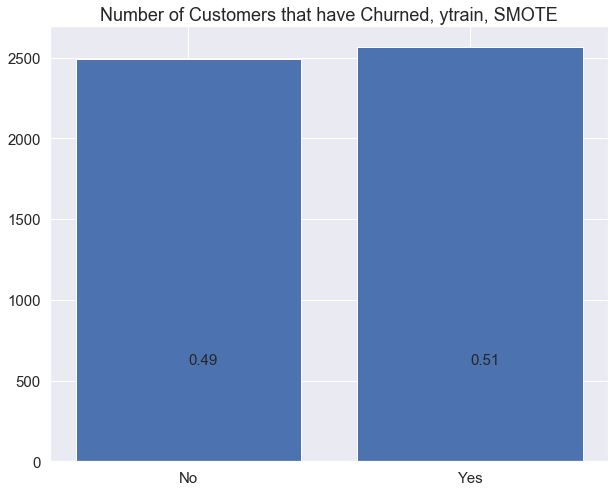

In [133]:
proportion_classes(ytrainsm, [1, 0], ['Yes','No'], 'Number of Customers that have Churned, ytrain, SMOTE')

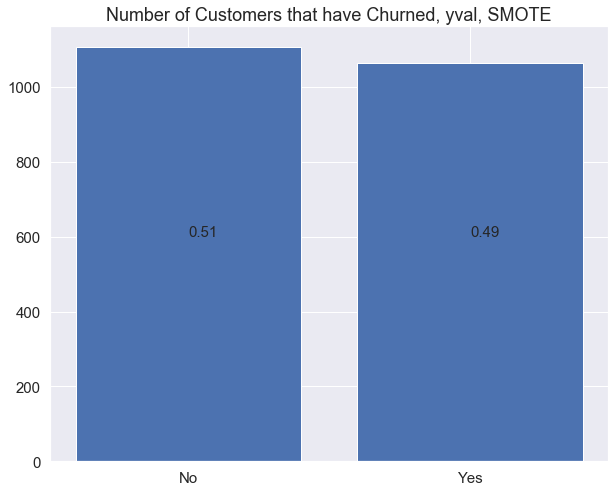

In [134]:
proportion_classes(yvalsm, [1, 0], ['Yes','No'], 'Number of Customers that have Churned, yval, SMOTE')

In [135]:
param_gridxg_sm = { 
    'learning_rate':[0.01, 0.1, 0.3, 0.35],
    'n_estimators': [50, 70, 100, 200, 250],
    'max_depth' : [4,5,6,7],
    'colsample_bytree': [0.3, 0.5, 0.7]
}

grid_xg_sm = RandomizedSearchCV(estimator=xg, param_distributions=param_gridxg_sm, cv=5, scoring='recall', random_state=37)

In [136]:
grid_xg_sm.fit(Xtrainsm, ytrainsm)

grid_xg_sm.best_params_

{'n_estimators': 70,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7}

In [138]:
y_xgsm = grid_xg_sm.predict(Xvalsm)
y_xg_probsm = grid_xg_sm.predict_proba(Xvalsm)


y_xg_features_sm = grid_xg_sm.best_estimator_.feature_importances_

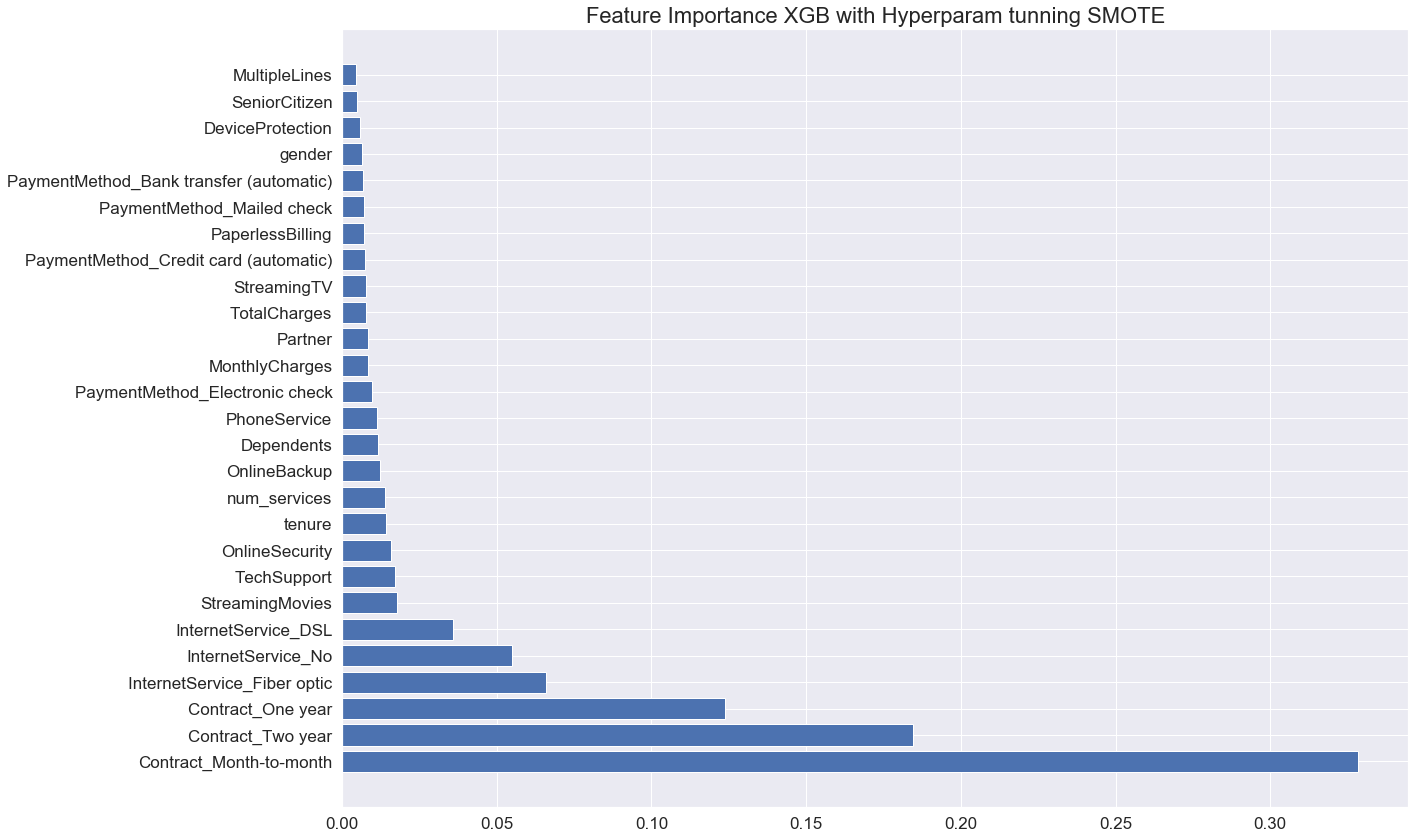

In [139]:
plot_feature_importance(y_xg_features_sm, Xvalsm.columns, 'XGB with Hyperparam tunning SMOTE', Xvalsm)

In [140]:
print(classification_report(yvalsm, y_xgsm))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1106
           1       0.78      0.87      0.83      1063

    accuracy                           0.82      2169
   macro avg       0.82      0.82      0.82      2169
weighted avg       0.82      0.82      0.82      2169



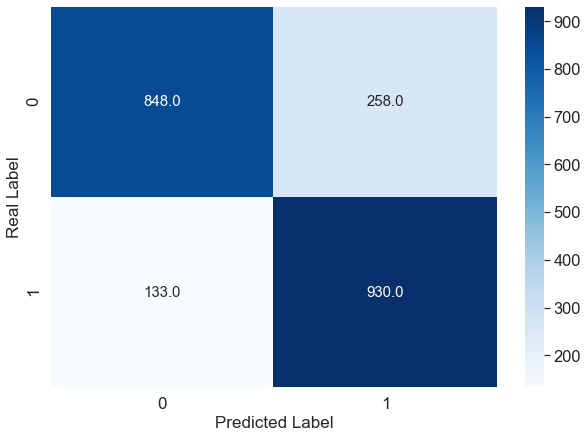

In [141]:
plot_confusion_matrix(yvalsm, y_xgsm)

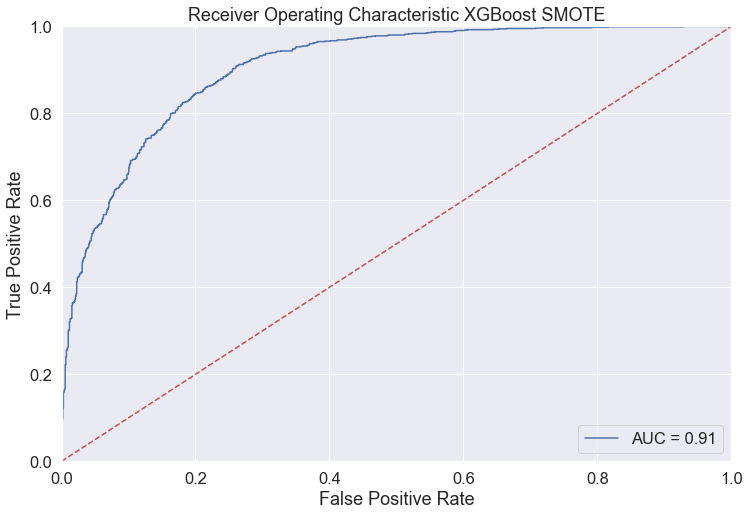

In [142]:
roc_curve_plot(Xvalsm, yvalsm, grid_xg_sm, 'XGBoost SMOTE')

https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction

As we can see from our SMOTE oversampling, both our training and validation sets are well balanced and the fit performed well when predicting which users will churn (recall: 0.87).

I want to update a few things in this notebook to make it easier to read and execute, like implementing a imblearn pipeline but for now, let's feed our model actual unseen data to see how it performs (our test set)

In [143]:
y_pred = grid_xg_sm.predict(Xtestsm)
print(classification_report(ytestsm, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1563
           1       0.79      0.86      0.82      1535

    accuracy                           0.82      3098
   macro avg       0.82      0.82      0.82      3098
weighted avg       0.82      0.82      0.82      3098



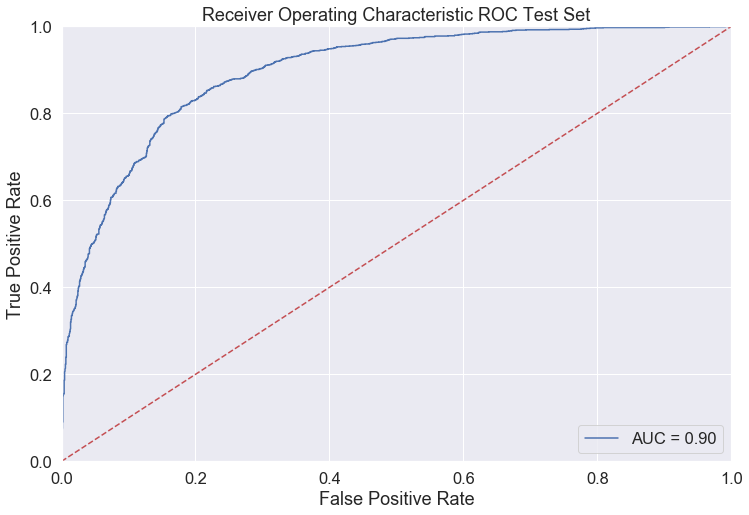

In [144]:
roc_curve_plot(Xtestsm, ytestsm, grid_xg_sm, 'ROC Test Set')

Our final Recall for the test set is 0.86 for churned customers and 0.77 for non-churn customers. I decided to maximize recall as a representative scenario in which a company will want to minimize churned individuals but is not affected by false positives as much as by false negatives.

It seems (as expected and we say in the waffle plots) that having a contract month-to-month represents a high turn over, since customers have an easier way to end their contracts. 